# Evaluating Fairness in Machine Learning: Comparative Analysis and Benchmarking of Fairlearn and AIF360 | COMPAS Recidivism Dataset

In [77]:
%load_ext autoreload
%autoreload 2

import os
import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

from src.constants import RANDOM_STATE, DEFAULT_MODEL_CONFIG, METRICFRAME_METRICS
from src.evaluation import plot_roc, print_confusion_matrix, calculate_fairlearn_metrics, calculate_aif360_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
sklearn.set_config(transform_output="pandas")

## Ensure reproducibility

Set random seeds for reproducibility.

In [79]:
np.random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Load data

In [80]:
FEATURES = ["sex",
            "age",
            "age_cat",
            "race",
            "juv_fel_count",
            "juv_misd_count",
            "juv_other_count",
            "priors_count",
            "days_b_screening_arrest",
            "c_days_from_compas",
            "c_charge_degree",
            "decile_score.1",
            "score_text",
            "v_type_of_assessment",
            "v_decile_score",
            "v_score_text",
            "end",
            ]
TARGET = "is_recid"
PROTECTED_ATTRIBUTE = "race"

In [81]:
data_raw = pd.read_csv("../data/compas-scores-two-years.csv", usecols=[*FEATURES, TARGET])
data = data_raw.copy()

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sex                      7214 non-null   object 
 1   age                      7214 non-null   int64  
 2   age_cat                  7214 non-null   object 
 3   race                     7214 non-null   object 
 4   juv_fel_count            7214 non-null   int64  
 5   juv_misd_count           7214 non-null   int64  
 6   juv_other_count          7214 non-null   int64  
 7   priors_count             7214 non-null   int64  
 8   days_b_screening_arrest  6907 non-null   float64
 9   c_days_from_compas       7192 non-null   float64
 10  c_charge_degree          7214 non-null   object 
 11  is_recid                 7214 non-null   int64  
 12  decile_score.1           7214 non-null   int64  
 13  score_text               7214 non-null   object 
 14  v_type_of_assessment    

In [83]:
data.isna().sum()

sex                          0
age                          0
age_cat                      0
race                         0
juv_fel_count                0
juv_misd_count               0
juv_other_count              0
priors_count                 0
days_b_screening_arrest    307
c_days_from_compas          22
c_charge_degree              0
is_recid                     0
decile_score.1               0
score_text                   0
v_type_of_assessment         0
v_decile_score               0
v_score_text                 0
end                          0
dtype: int64

In [84]:
data[TARGET].value_counts()

is_recid
0    3743
1    3471
Name: count, dtype: int64

In [85]:
data[PROTECTED_ATTRIBUTE].value_counts()

race
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: count, dtype: int64

In [86]:
y = data[TARGET]
z = data[PROTECTED_ATTRIBUTE]
X = data.drop(columns=TARGET)

In [87]:
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [88]:
MODEL_CONFIG = dict(DEFAULT_MODEL_CONFIG, cat_features=X.select_dtypes("object").columns.to_list())

In [89]:
default_model = CatBoostClassifier(**MODEL_CONFIG)
model = default_model.copy()

In [90]:
model.fit(X_train, y_train)

0:	learn: 0.6844627	total: 3.39ms	remaining: 10.2s
250:	learn: 0.3208956	total: 766ms	remaining: 8.39s
500:	learn: 0.3091280	total: 1.54s	remaining: 7.68s
750:	learn: 0.3038870	total: 2.34s	remaining: 7s
1000:	learn: 0.2994238	total: 3.15s	remaining: 6.29s
1250:	learn: 0.2951383	total: 3.92s	remaining: 5.48s
1500:	learn: 0.2916133	total: 4.68s	remaining: 4.67s
1750:	learn: 0.2886633	total: 5.49s	remaining: 3.92s
2000:	learn: 0.2859524	total: 6.29s	remaining: 3.14s
2250:	learn: 0.2837542	total: 7.08s	remaining: 2.35s
2500:	learn: 0.2815680	total: 7.87s	remaining: 1.57s
2750:	learn: 0.2795766	total: 8.67s	remaining: 785ms
2999:	learn: 0.2775952	total: 9.55s	remaining: 0us


In [91]:
y_pred = pd.Series(model.predict(X_test), name="y_pred", index=y_test.index)

In [92]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       749
           1       0.84      0.92      0.88       694

    accuracy                           0.88      1443
   macro avg       0.88      0.88      0.88      1443
weighted avg       0.88      0.88      0.88      1443


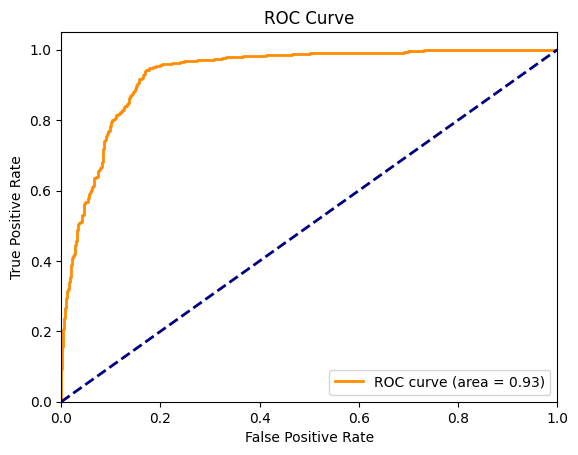

In [93]:
fig, ax = plt.subplots()
plot_roc(model, X_test, y_test, ax)

In [94]:
print_confusion_matrix(model, X_test, y_test)

Confusion Matrix:
[[631 118]
 [ 58 636]]


## Fairness assessment

### Fairlearn

#### Detection

In [105]:
from fairlearn.metrics import MetricFrame

In [106]:
mf = MetricFrame(
    metrics=METRICFRAME_METRICS,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=z_test,
    random_state=RANDOM_STATE,
)

In [107]:
mf.overall

tpr         0.916427
fpr         0.157543
sel         0.522523
count    1443.000000
dtype: float64

In [108]:
mf.by_group

,tpr,fpr,sel,count
race,,,,
African-American,0.919240,0.179739,0.607978,727.0
Asian,0.666667,0.142857,0.300000,10.0
Caucasian,0.914573,0.148649,0.456566,495.0
Hispanic,0.914894,0.137931,0.410448,134.0
Native American,1.000000,0.000000,1.000000,3.0
Other,0.904762,0.113208,0.337838,74.0


In [109]:
calculate_fairlearn_metrics(y_test, y_pred, z_test)

,metric,type,method,value
8,demographic_parity,difference,between_groups,0.700000
10,demographic_parity,difference,to_overall,0.477477
9,demographic_parity,ratio,between_groups,0.300000
11,demographic_parity,ratio,to_overall,0.522523
0,equal_opportunity,difference,between_groups,0.333333
2,equal_opportunity,difference,to_overall,0.249760
1,equal_opportunity,ratio,between_groups,0.666667
3,equal_opportunity,ratio,to_overall,0.727463
4,equalized_odds,difference,between_groups,0.333333
6,equalized_odds,difference,to_overall,0.249760


#### Mitigation

In [110]:
from fairlearn.reductions import DemographicParity, ExponentiatedGradient

In [111]:
reduction = ExponentiatedGradient(estimator=default_model.copy(), constraints=DemographicParity(difference_bound=0.01), max_iter=10)
reduction.fit(X_train, y_train, sensitive_features=z_train)

/opt/homebrew/Caskroom/miniconda/base/envs/fairness-toolkits/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/opt/homebrew/Caskr

0:	learn: 0.6844627	total: 9.15ms	remaining: 27.4s
250:	learn: 0.3208956	total: 1.21s	remaining: 13.2s
500:	learn: 0.3091280	total: 2.39s	remaining: 11.9s
750:	learn: 0.3038870	total: 3.42s	remaining: 10.2s
1000:	learn: 0.2994238	total: 4.63s	remaining: 9.24s
1250:	learn: 0.2951383	total: 5.94s	remaining: 8.3s
1500:	learn: 0.2916133	total: 7.25s	remaining: 7.24s
1750:	learn: 0.2886633	total: 8.46s	remaining: 6.03s
2000:	learn: 0.2859524	total: 9.15s	remaining: 4.57s
2250:	learn: 0.2837542	total: 9.85s	remaining: 3.28s
2500:	learn: 0.2815680	total: 10.5s	remaining: 2.1s
2750:	learn: 0.2795766	total: 11.2s	remaining: 1.02s
2999:	learn: 0.2775952	total: 12s	remaining: 0us
0:	learn: 0.6844627	total: 6.56ms	remaining: 19.7s
250:	learn: 0.3208956	total: 956ms	remaining: 10.5s
500:	learn: 0.3091280	total: 1.61s	remaining: 8.02s
750:	learn: 0.3038870	total: 2.27s	remaining: 6.79s
1000:	learn: 0.2994238	total: 2.97s	remaining: 5.93s
1250:	learn: 0.2951383	total: 3.65s	remaining: 5.1s
1500:	lear

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x2c045a980>,
                      estimator=<catboost.core.CatBoostClassifier object at 0x2c045af80>,
                      max_iter=10, nu=0.0020654979885385933)

In [112]:
y_pred_reduced = reduction.predict(X_test)

In [113]:
print(classification_report(y_test, y_pred_reduced))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       749
           1       0.83      0.86      0.85       694

    accuracy                           0.85      1443
   macro avg       0.85      0.85      0.85      1443
weighted avg       0.85      0.85      0.85      1443


### AIF360

#### Detection

_"Since the main computation of confusion matrices is common for a large set of metrics, we utilize memoization and caching of computations for performance on large-scale datasets."_

In [114]:
priv_group = "Caucasian"

In [115]:
calculate_aif360_metrics(y_test, y_pred, z_test, priv_group=priv_group)

NameError: name 'calculate_aif360_metrics' is not defined

#### Mitigation

In [ ]:
from aif360.sklearn.inprocessing import ExponentiatedGradientReduction as ExponentiatedGradientReductionAif

In [ ]:
reduction_aif = ExponentiatedGradientReductionAif(prot_attr=PROTECTED_ATTRIBUTE, estimator=default_model.copy(), constraints=DemographicParity(difference_bound=0.01), max_iter=10)

In [ ]:
reduction_aif.fit(X_train, y_train)

In [ ]:
y_pred_reduced_aif = reduction_aif.predict(X_test)

In [ ]:
calculate_aif360_metrics(y_test, y_pred_reduced_aif, z_test, priv_group=priv_group)

In [ ]:
print(classification_report(y_test, y_pred_reduced_aif))
